# Trabajo Practico - Desarrollo de software para el cálculo de parámetros acústicos ISO 3382 (1er entrega)

## Fecha de entrega

10/10/

## Integrantes

* <Marcos, García Giorgi>
* <Joaquin, Duhalde>

## Aspectos generales del notebook

* Todas las funciones deben contar con su [docstring](https://realpython.com/documenting-python-code/#docstring-types), como figura en la funcion de ejemplo (`ruidoRosa_voss`).
* Todos los gráficos deben tener correctamente etiquetados los ejes.
* Enviar el notebook (.ipynb) (con las celdas ejecutas) y todos los archivos para reproducir los resultados por Slack.
* Todas las señales de audio deben ser generadas en formato .wav en una función nueva.

## Librerias utilizadas
Agregar todas las librerias utilizadas, algunas a modo de ejemplo:

In [22]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import soundfile as sf
import matplotlib.pyplot as plt
from scipy.signal import welch
import sounddevice as sd
import time


## Función de sintetización de ruido rosa
El ruido rosa o ruido $\frac{1}{\sqrt{f}}$ , dónde $f$ denota frecuencia en Hz, es un ruido con una distribución de frecuencias tal que su densidad espectral de potencia es proporcional a la inversa de la frecuencia. Esto implica que su nivel, por bandas de tercio de octava, es constante. El nivel del ruido rosa por intervalo fijo de frecuencias va decayendo a razón de 3 dB/octava, de forma no lineal aunque las frecuencias se representan en un eje lineal.

![Espectro del ruido rosa](../img/image44.png)
<center><b>Fig 1.</b> Espectro del ruido rosa.</center>

Se adjunta a continuación una función que devuelva un ruido rosa sintetizado a partir del algoritmo de Voss y Clarke (pueden encontrar mas informacion en [este enlace](https://www.dsprelated.com/showabstract/3933.php) y en [este notebook](https://github.com/AllenDowney/ThinkDSP/blob/master/code/voss.ipynb)). 

**Consigna:** modificar la función original para que reciba como parametro la duración del ruido en segundos $t$ y como parametro opcional la frecuencia de muestreo $fs$ (Ayuda: la longitud de la señal sera el producto entre ambos). La función debe guardar el archivo de audio .wav de la señal generada y devolver el vector de datos de la señal.

In [23]:
def ruidoRosa_voss(t,ncols=16,fs=44100):
    """
    Genera ruido rosa utilizando el algoritmo de Voss-McCartney(https://www.dsprelated.com/showabstract/3933.php).
    
    .. Nota:: si 'ruidoRosa.wav' existe, este será sobreescrito
    
    Parametros
    ----------
    t : float
        Valor temporal en segundos, este determina la duración del ruido generado.
    rcols: int
        Determina el número de fuentes a aleatorias a agregar.
    fs: int
        Frecuencia de muestreo en Hz de la señal. Por defecto el valor es 44100 Hz.
    
    returns: NumPy array
        Datos de la señal generada.
    
    Ejemplo
    -------
    Generar un .wav desde un numpy array de 10 segundos con ruido rosa a una 
    frecuencia de muestreo de 44100 Hz.
    
        import numpy as np
        import soundfile as sf
        from scipy import signal
        
        ruidoRosa_voss(10)
    """
    nrows=int(t*fs)
    array = np.full((nrows, ncols), np.nan)
    array[0, :] = np.random.random(ncols)
    array[:, 0] = np.random.random(nrows)
    
    # el numero total de cambios es nrows
    n = nrows
    cols = np.random.geometric(0.5, n)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=n)
    array[rows, cols] = np.random.random(n)
    
    df = pd.DataFrame(array)
    filled = df.fillna(method='ffill', axis=0)
    total = filled.sum(axis=1)
    
    ## Centrado de el array en 0
    total = total - total.mean()
    
    ## Normalizado
    valor_max = max(abs(max(total)),abs(min(total)))
    total = total / valor_max
    
    # Agregar generación de archivo de audio .wav
    sf.write('ruidoRosa.wav', total, fs)
    
    ## Plot de total en cantidad de muestras (t*fs)
    plt.plot(total)

    
    return total

Llamar la función.

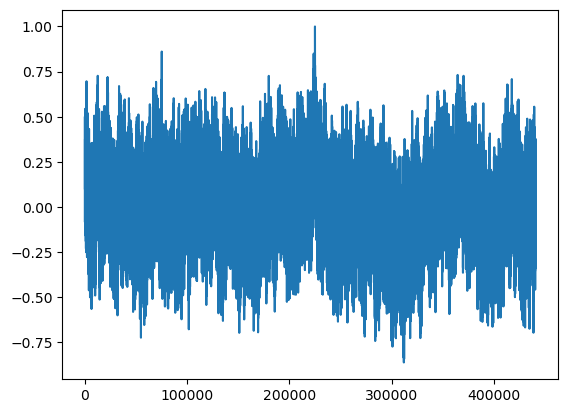

In [24]:
t=10
audio = ruidoRosa_voss(t)


Realizar una función para visualizar el dominio temporal de la señal.

In [25]:
def plot_dominio_temporal(señal, fs= 44100):
    """
    Muestra el dominio temporal de la señal.

    Parametros
    ----------
    señal : NumPy array
        Señal a mostrar en el dominio temporal.
    fs : int
        Frecuencia de muestreo en Hz de la señal.

    Returns
    -------
    None
    """
    # Calcula los valores de tiempo
    tiempo = np.arange(len(señal)) / fs

    # Crea una nueva figura y plotea la señal
    plt.figure(figsize=(10, 4))
    plt.plot(tiempo, señal)
    plt.title('Dominio Temporal de la Señal')
    plt.xlabel('Tiempo (segundos)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()


Llamar a la función.

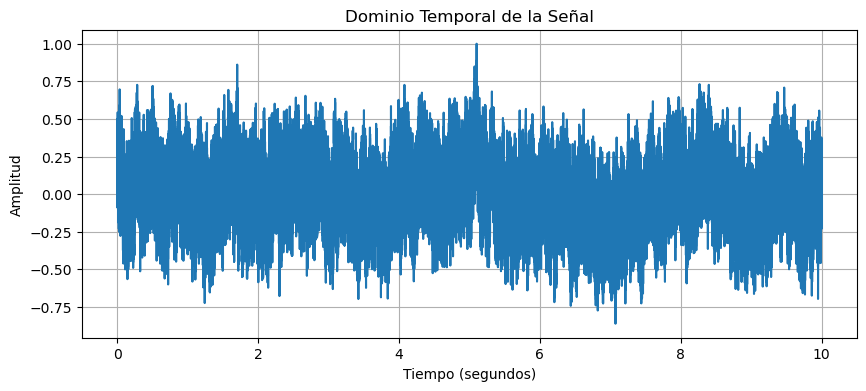

In [26]:

plot_dominio_temporal(audio)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

![Espectro del ruido rosa](Documents/Audacity(RR))


Reproducir resultado.

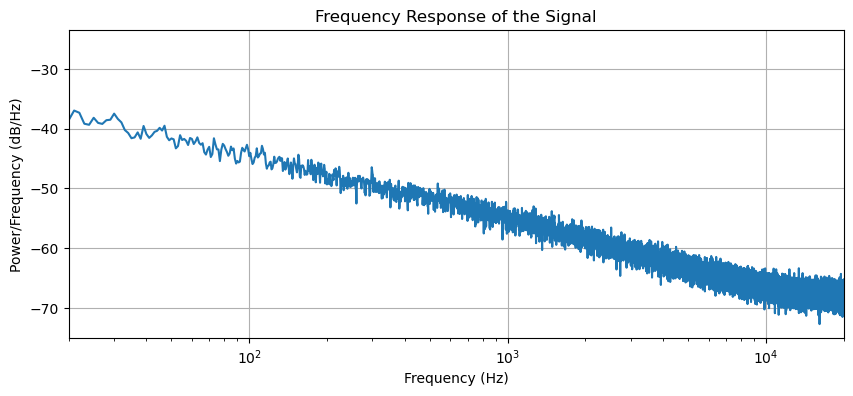

In [27]:
def plot_frequency_response(signal, fs=44100):
    """
    Grafica la respuesta en frecuencia de la señal en decibeles (dB).

    Parametros:
    signal (numpy array): La señal de entrada.
    fs (int): Frecuencia de sampleo de la señal.

    Returns:
    None
    """
    f, Pxx = welch(signal, fs=44100, nperseg=44100)
    plt.figure(figsize=(10, 4))
    plt.semilogx(f, 10 * np.log10(Pxx))
    plt.title('Frequency Response of the Signal')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power/Frequency (dB/Hz)')
    plt.grid(True)
    plt.xlim([20, 20000])
    plt.show()
    
plot_frequency_response(audio)    

> Solo a modo de comentario, un **método alternativo** es utilizando un filtro en el siguiente [link](https://ccrma.stanford.edu/~jos/sasp/Example_Synthesis_1_F_Noise.html) se presenta la implementación en Matlab/Octave.

## Funcion de generación de sine sweep logaritmico + filtro inverso
El sine sweep es el método más indicado para generar el impulso por medio de la convolución (Nikolić, I., and O. H. Bjor, 2003). Dado que métodos tales como: explosión de globo, aplauso, disparo con pistola se salva, paper gun ([Paper Popper](https://en.wikipedia.org/wiki/Paper_popper)), golpe entre maderas, petardos, entre otros, carecen de reproducibilidad. Esto es debido a su nivel sonoro, duración y características espectrales, además de una muy baja relación señal ruido, la cual difícilmente se solucione filtrando o promediando con muchas mediciones. Comencemos por ver cómo generar el sine sweep logarítmico $x(t)$ que posee la siguiente forma:

\begin{equation}
f(x) = \sin[\theta(t)]= \sin[K (e^\frac{t}{L} - 1) ]
\tag{1}
\end{equation}

Donde:

\begin{equation}
K = \frac{T w_{1}}{R}
\end{equation}

\begin{equation}
L = \frac{T}{R}
\end{equation}

y el sweep rate $R$: 

\begin{equation}
R = \ln \left( \frac{w_{2}}{w_{1}} \right)
\tag{2}
\end{equation}

Con $w_{1}$ y $w_{2}$, las frecuencias angulares inferior y superior respectivamente, $T$ es el tiempo de duración del sine sweep en segundos (Meng, Q., 2008). Si estudiamos el espectro de la señal de la ecuación (1), se observa que no es plano, sino que disminuye a razón de -3 dB/octava, como el ruido rosa (Ver fig. 2, sup). De modo que el espectro de $x(-t)$ debe ser ajustado, aumentando en 3 dB/octava, de modo que cuando realizamos el cálculo se restaure la plenitud perfecta de la respuesta de impulso medida $h(t)$ (Farina A., 2000) (Ver fig. 2, inf).

![](../img/image43.png)
<center><b>Fig 2.</b> Espectro del sine sweep. Sine sweep logarítmico  (sup). Filtro invertido (inf).</center>


En el dominio temporal las señales del sine sweep logarítmico y el filtro inverso se comportan de la siguiente manera (Ver fig. 3). 

![](../img/image46.png)
<center><b>Fig 3.</b> Magnitud del sine sweep. Sine sweep logarítmico (sup). Filtro invertido (inf).</center>

Para generar el filtro inverso $k(t)$ del sine sweep logarítmico $x(t)$ se requiere de una modulación $m(t)$ definida por la siguiente expresión:

\begin{equation}
m(t) = \frac{w_{1}}{2\pi w(t)}
\tag{3}
\end{equation}

Obtenida de la frecuencia instantánea (dado que la amplitud cambia en función de la
frecuencia), calculada a partir de la ecuación (1):

\begin{equation}
w(t)=\frac{d[\theta (t)]}{dt}=\frac{K}{L} e^\frac{t}{L}
\tag{4}
\end{equation}
m
entonces, el filtro inverso $k(t)$ queda definido como:

\begin{equation}
k(t)=m(t)x(-t)
\tag{5}
\end{equation}

**Consigna:** realizar una función generadora de un sine sweep y su filtro inverso, a partir de las ecuaciones descriptas anteriormente, y graficar el resultado de ambos filtros, usando la función anteriormente creada. Recordar almacenar los audios. Agregar docstring que indique claramente los parametros de entrada y salida.

In [31]:
def generar_sine_sweep_y_inversa(duracion, frec_comienzo, freq_final, fs=44100):
    """
    Genera un sine sweep logaritmico y su correspondiente filtro inverso.

    Parametros:
    duracion (float): Duracion del Sine Sweep en segundos.
    frec_comienzo(float):frequencia de comienzo en Hz.
    freq_final (float): frecuencia final en Hz.
    fs (int):frecuencia de sampleo en Hz. Predeterminado en 44100 Hz.

    Returns:
    tuple: Una tupla que contiene el sine sweep logaritmico generado
    """
    t = np.linspace(0, duracion, int(fs * duracion), endpoint=False)
    

    # Calcula el escalamiento de amplitud para cada fercuencia
    freqs = np.exp(np.linspace(np.log(frec_comienzo), np.log(freq_final), len(t)))

    # Genera el Sine Sweep 
    sine_sweep = np.sin(np.cumsum(2 * np.pi * freqs / fs))

    # Normaliza el Sine Sweep
    sine_sweep /= np.max(np.abs(sine_sweep))


    t_swipe_arange = np.arange(0, duracion*fs)/fs  # Arreglo de muestreos
    R = np.log(freq_final/frec_comienzo)  # Ratio del Sweep
    K = duracion*2*np.pi*frec_comienzo/R
    L = duracion/R
    w = (K/L)*np.exp(t_swipe_arange/L)
    m = frec_comienzo/w

    # Calcula el filtro inverso  k(t)
    x_t = sine_sweep
    k_t = m * x_t[::-1]  #  Inversion temporal de x(t)

    # Normaliza el Filtro Inverso 
    k_t /= np.max(np.abs(k_t))
    
    # Calcula el eje de tiempo  en segundos
    tiempo_segundos = np.linspace(0, duracion, len(sine_sweep), endpoint=False)    

    # Plotea el Sine Sweep generado
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(tiempo_segundos, sine_sweep)
    plt.title('Sine Sweep logaritmico')
    plt.xlabel('Tiempo (seconds)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotea el Filtro Inverso 
    plt.figure(figsize=(10, 4))
    plt.plot(t, k_t)
    plt.title('Filtro Inverso k(t)')
    plt.xlabel('Tiempo (seconds)')
    plt.ylabel('Amplitud')
    plt.grid(True)
    plt.show()
    
    # Guarda el filtro inverso k(t) como archivo de audio .wav
    sf.write('filtro_inverso.wav', k_t, fs)
   
    return sine_sweep

Llamar la función.

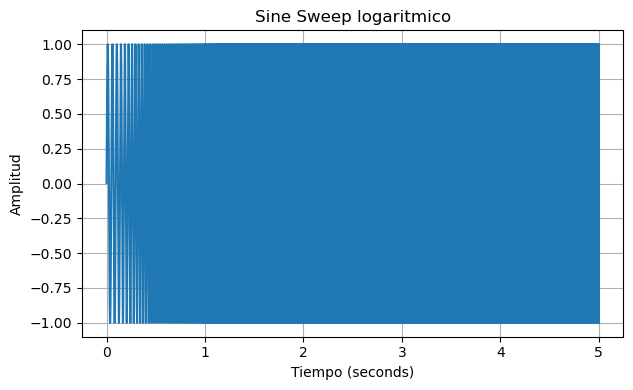

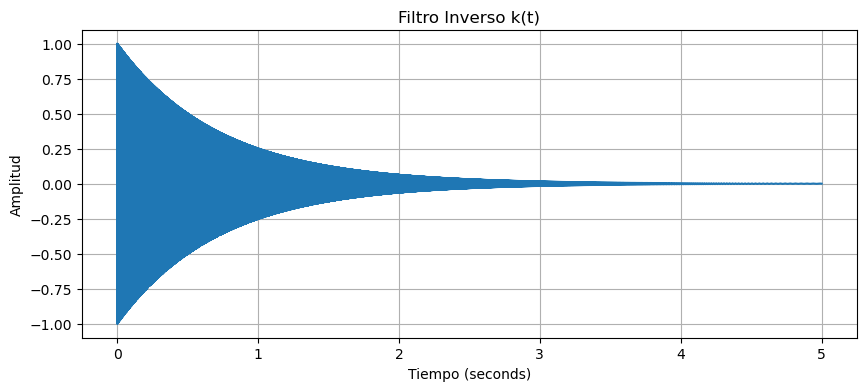

In [32]:
# Parámetros del sine sweep logarítmico
duracion = 5  # Duración en segundos
frec_comienzo = 20  # Frecuencia inicial en Hz
freq_final = 20000  # Frecuencia final en Hz
fs = 44100  # Frecuencia de muestreo en Hz

sine_sweep = generar_sine_sweep_y_inversa(duracion, frec_comienzo, freq_final, fs=44100)
# Guarda el Sine Sweep como archivo de audio .wav
sf.write('sine_sweep_log.wav', sine_sweep, fs)

Graficar el dominio espectral del resultado utilizando el [software Audacity](https://www.audacityteam.org/) (Ayuda: [Plot Spectrum Audacity](https://manual.audacityteam.org/man/plot_spectrum.html))

![Espectro del SineSweep](Documents/Audacity(SS))
![Espectro del FiltroInverso](Documents/Audacity(FI))

Reproducir resultados.

## Función adquisicion y reproducción
**Consigna**: la función tiene que permitir la reproducción y la adquisición de manera simultánea para un tiempo determinado por el usuario. Es importante evaluar y constatar dicha simultaneidad. El módulo debería permitir seleccionar el hardware a utilizar. Algunos articulos de interes para el desarrollo:
* [Clase de audio](../../clases/clase_6/600_audio.ipynb)
* [Sound Device - Simultaneous Playback and Recording](https://python-sounddevice.readthedocs.io/en/0.4.1/usage.html#simultaneous-playback-and-recording)
* [Playing and Recording Sound in Python](https://realpython.com/playing-and-recording-sound-python/)
* [Audio in Python](https://wiki.python.org/moin/Audio/)
* [https://github.com/spatialaudio/python-sounddevice/issues/148](https://github.com/spatialaudio/python-sounddevice/issues/148)

In [44]:
def grabar_señal(señal, disp_entrada, disp_salida, duracion):
    """
    Reproducción y grabación de una señal en formato ".wav" en simultáneo.

    Parámetros
    ----------
    signal: Archivo ".wav"

    disp_entrada: int
        Dispositivo de grabación de audio.
    
    disp_salida: int
        Dispositivo de reproducción de audio.

    duracion: 
        Tiempo de grabación de la señal.

    Para ver el listado de dispositivos de audio: 
    
    import sounddevice as sd
    sd.query_devices()
        
    Ejemplo
    -------
    import numpy as np
    import soundfile as sf
    import sounddevice as sd
    
    señal = 'SineSweepLog.wav'
    disp_entrada = 1
    disp_salida = 9
    grabar_señal(señal, disp_entrada, disp_salida)
    
    """
    
    # Selección de dispositivos de audio
    sd.default.device = disp_entrada, disp_salida
    # Reproducción de la señal y grabación en simultáneo   
    data, fs = sf.read(señal, dtype='float32')
    samples_rec = duracion*fs
    val = data[0:samples_rec]
    grabacion_señal = sd.playrec(val, fs, channels=1)
    sd.wait()
    sf.write('signal_recording.wav', grabacion_señal,fs )  # Guardo el archivo .wav
    return grabar_señal


Llamar la función.

In [45]:
señal = 'sine_sweep_log.wav'
grabacion = grabar_señal(señal,10,10,5)


¿Cómo se podría medir la latencia de la función? Agregar un gráfico.

In [53]:
import time 
import pyaudio
import wave

# Set parameters
FORMAT = pyaudio.paInt16
CHANNELS = 2
RATE = 44100
CHUNK = 1024
RECORD_SECONDS = 5

# Initialize PyAudio
audio = pyaudio.PyAudio()

# Open input stream
input_device_index = 0 # Replace with the index of your input device
stream_in = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, input=True,
                frames_per_buffer=CHUNK,
                input_device_index=input_device_index)

# Open output stream
output_device_index = 0 # Replace with the index of your output device
stream_out = audio.open(format=FORMAT, channels=CHANNELS,
                rate=RATE, output=True,
                frames_per_buffer=CHUNK,
                output_device_index=output_device_index)

# Registra el tiempo de inicio
inicio = time.time()

# Record and play audio
frames = []
for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream_in.read(CHUNK)
    frames.append(data)
    stream_out.write(data)

# Registra el tiempo de finalización
final = time.time()

# Stop streams
stream_in.stop_stream()
stream_out.stop_stream()
stream_in.close()
stream_out.close()

# Terminate PyAudio
audio.terminate()
latencia = final - inicio

latencia_milisegundos = latencia * 1000

print(f'Latencia de la función grabar_reproducir_audio: {round(latencia_milisegundos,2)} ms')
  

OSError: [Errno -9999] Unanticipated host error